<a href="https://colab.research.google.com/github/jindavid/inverseFNO/blob/main/solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
PATH = '/home/jovyan/project/data'

In [11]:
# setup env 1.7.1
!sh solver_setup.sh

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [10]:
import torch
import math
import numpy as np

import matplotlib.pyplot as plt

# from random_fields import GaussianRF
import matplotlib.animation as animation

from timeit import default_timer
import scipy.io
from utilities4 import *

/srv/conda/envs/saturn/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
class KolmogorovFlow2d(object):

    def __init__(self, w0, Re, n):

        #Grid size
        self.s = w0.size()[-1]

        assert self.s == w0.size()[-2], "Grid must be uniform in both directions."

        assert math.log2(self.s).is_integer(), "Grid size must be power of 2."

        assert n >= 0 and isinstance(n, int), "Forcing number must be non-negative integer."

        assert n < self.s//2 - 1, "Forcing number too large for grid size."

        #Forcing number
        self.n = n

        assert Re > 0, "Reynolds number must be positive."

        #Reynolds number
        self.Re = Re

        #Device
        self.device = w0.device

        #Current time
        self.time = 0.0

        #Current vorticity in Fourier space
        self.w_h = torch.rfft(w0, 2, normalized=False, onesided=False)

        #Wavenumbers in y and x directions
        self.k_y = torch.cat((torch.arange(start=0, end=self.s//2, step=1, dtype=torch.float32, device=self.device),\
                              torch.arange(start=-self.s//2, end=0, step=1, dtype=torch.float32, device=self.device)), 0).repeat(self.s,1)

        self.k_x = self.k_y.clone().transpose(0,1)

        #Negative inverse Laplacian in Fourier space
        self.inv_lap = (self.k_x**2 + self.k_y**2)
        self.inv_lap[0,0] = 1.0
        self.inv_lap = 1.0/self.inv_lap

        #Negative scaled Laplacian
        self.G = (1.0/self.Re)*(self.k_x**2 + self.k_y**2)

        #Dealiasing mask using 2/3 rule
        self.dealias = (self.k_x**2 + self.k_y**2 <= (self.s/3.0)**2).float()
        #Ensure mean zero
        self.dealias[0,0] = 0.0

    #Get current vorticity from stream function (Fourier space)
    def vorticity(self, stream_f=None, real_space=True):
        if stream_f is not None:
            w_h = torch.empty_like(stream_f)
            w_h[...,0] = self.Re*self.G*stream_f[...,0]
            w_h[...,1] = self.Re*self.G*stream_f[...,1]
        else:
            w_h = self.w_h

        if real_space:
            return torch.irfft(w_h, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))
        else:
            return w_h

    #Compute stream function from vorticity (Fourier space)
    def stream_function(self, w_h=None, real_space=False):
        if w_h is None:
            psi_h = self.w_h.clone()
        else:
            psi_h = w_h.clone()

        #Stream function in Fourier space: solve Poisson equation
        psi_h[...,0] = self.inv_lap*psi_h[...,0]
        psi_h[...,1] = self.inv_lap*psi_h[...,1]

        if real_space:
            return torch.irfft(psi_h, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))
        else:
            return psi_h

    #Compute velocity field from stream function (Fourier space)
    def velocity_field(self, stream_f=None, real_space=True):
        if stream_f is None:
            stream_f = self.stream_function(real_space=False)

        #Velocity field in x-direction = psi_y
        q_h = stream_f.clone()
        temp = q_h[...,0].clone()
        q_h[...,0] = -self.k_y*q_h[...,1]
        q_h[...,1] = self.k_y*temp

        #Velocity field in y-direction = -psi_x
        v_h = stream_f.clone()
        temp = v_h[...,0].clone()
        v_h[...,0] = self.k_x*v_h[...,1]
        v_h[...,1] = -self.k_x*temp

        if real_space:
            q = torch.irfft(q_h, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))
            v = torch.irfft(v_h, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))
            return q, v
        else:
            return q_h, v_h

    #Compute non-linear term + forcing from given vorticity (Fourier space)
    def nonlinear_term(self, w_h):
        #Physical space vorticity
        w = torch.irfft(w_h, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))

        #Velocity field in physical space
        q, v = self.velocity_field(self.stream_function(w_h, real_space=False), real_space=True)

        #Compute non-linear term
        t1 = torch.rfft(q*w, 2, normalized=False, onesided=False)
        t1[...,0] = self.k_x*t1[...,0]
        t1[...,1] = self.k_x*t1[...,1]

        t2 = torch.rfft(v*w, 2, normalized=False, onesided=False)
        t2[...,0] = self.k_y*t2[...,0]
        t2[...,1] = self.k_y*t2[...,1]

        nonlin = t1 + t2
        temp = nonlin[...,0].clone()
        nonlin[...,0] = nonlin[...,1]
        nonlin[...,1] = -temp

        #Apply forcing: -ncos(ny)
        if self.n > 0:
            nonlin[...,0,self.n,0] -= (float(self.n)/2.0)*(self.s**2)
            nonlin[...,0,-self.n,0] -= (float(self.n)/2.0)*(self.s**2)

        return nonlin

    def advance(self, t, delta_t=1e-3):

        #Final time
        T = self.time + t

        #Advance solution in Fourier space
        while self.time < T:

            if self.time + delta_t > T:
                current_delta_t = T - self.time
            else:
                current_delta_t = delta_t

            #Inner-step of Heun's method
            nonlin1 = self.nonlinear_term(self.w_h)

            w_h_tilde = torch.empty_like(self.w_h)
            w_h_tilde[...,0] = (self.w_h[...,0] + current_delta_t*(nonlin1[...,0] - 0.5*self.G*self.w_h[...,0]))/(1.0 + 0.5*current_delta_t*self.G)
            w_h_tilde[...,1] = (self.w_h[...,1] + current_delta_t*(nonlin1[...,1] - 0.5*self.G*self.w_h[...,1]))/(1.0 + 0.5*current_delta_t*self.G)

            #Cranck-Nicholson + Heun update
            nonlin2 = self.nonlinear_term(w_h_tilde)

            self.w_h[...,0] = (self.w_h[...,0] + current_delta_t*(0.5*(nonlin1[...,0] + nonlin2[...,0]) - 0.5*self.G*self.w_h[...,0]))/(1.0 + 0.5*current_delta_t*self.G)
            self.w_h[...,1] = (self.w_h[...,1] + current_delta_t*(0.5*(nonlin1[...,1] + nonlin2[...,1]) - 0.5*self.G*self.w_h[...,1]))/(1.0 + 0.5*current_delta_t*self.G)

            #De-alias
            self.w_h[...,0] *= self.dealias
            self.w_h[...,1] *= self.dealias

            self.time += current_delta_t


class LinearKolmogorovFlow2d(object):

    def __init__(self, w0, Re, n):

        #Grid size
        self.s = w0.size()[-1]

        assert self.s == w0.size()[-2], "Grid must be uniform in both directions."

        assert math.log2(self.s).is_integer(), "Grid size must be power of 2."

        assert n >= 0 and isinstance(n, int), "Forcing number must be non-negative integer."

        assert n < self.s//2 - 1, "Forcing number too large for grid size."

        #Forcing number
        self.n = n

        assert Re > 0, "Reynolds number must be positive."

        #Reynolds number
        self.Re = Re

        #Device
        self.device = w0.device

        #Current time
        self.time = 0.0

        #Current vorticity in Fourier space
        self.w_h = torch.rfft(w0, 2, normalized=False, onesided=False)

        #Wavenumbers in y and x directions
        self.k_y = torch.cat((torch.arange(start=0, end=self.s//2, step=1, dtype=torch.float32, device=self.device),\
                              torch.arange(start=-self.s//2, end=0, step=1, dtype=torch.float32, device=self.device)), 0).repeat(self.s,1)

        self.k_x = self.k_y.clone().transpose(0,1)

        #Negative inverse Laplacian in Fourier space
        self.inv_lap = (self.k_x**2 + self.k_y**2)
        self.inv_lap[0,0] = 1.0
        self.inv_lap = 1.0/self.inv_lap

        #Negative scaled Laplacian
        self.G = (1.0/self.Re)*(self.k_x**2 + self.k_y**2)

        #Dealiasing mask using 2/3 rule
        self.dealias = (self.k_x**2 + self.k_y**2 <= (self.s/3.0)**2).float()
        #Ensure mean zero
        self.dealias[0,0] = 0.0

    #Get current vorticity
    def vorticity(self, real_space=True):
        if real_space:
            return torch.irfft(self.w_h, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))
        else:
            return self.w_h

    #Compute stream function
    def stream_function(self, w_h, real_space=False):
        psi_h = w_h.clone()

        #Stream function in Fourier space: solve Poisson equation
        psi_h[...,0] = self.inv_lap*psi_h[...,0]
        psi_h[...,1] = self.inv_lap*psi_h[...,1]

        if real_space:
            return torch.irfft(psi_h, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))
        else:
            return psi_h

    #Compute velocity field
    def velocity_field(self, w_h, real_space=True):
        stream_f = self.stream_function(w_h, real_space=False)

        #Velocity field in x-direction = psi_y
        q_h = stream_f.clone()
        temp = q_h[...,0].clone()
        q_h[...,0] = -self.k_y*q_h[...,1]
        q_h[...,1] = self.k_y*temp

        #Velocity field in y-direction = -psi_x
        v_h = stream_f.clone()
        temp = v_h[...,0].clone()
        v_h[...,0] = self.k_x*v_h[...,1]
        v_h[...,1] = -self.k_x*temp

        if real_space:
            q = torch.irfft(q_h, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))
            v = torch.irfft(v_h, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))
            return q, v
        else:
            return q_h, v_h

    #Compute transport term
    def transport_term(self, w_h, u01, u02, w0x, w0y, real_space=False):
        u11, u12 = self.velocity_field(w_h, real_space=True)

        #x-partial of vorticity
        w1x = w_h.clone()
        temp = w1x[...,0].clone()
        w1x[...,0] = -self.k_x*w1x[...,1]
        w1x[...,1] = self.k_x*temp
        w1x = torch.irfft(w1x, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))

        #y-partial of vorticity
        w1y = w_h.clone()
        temp = w1y[...,0].clone()
        w1y[...,0] = -self.k_y*w1y[...,1]
        w1y[...,1] = self.k_y*temp
        w1y = torch.irfft(w1y, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))

        transport_term = -(u11*w0x + u12*w0y + u01*w1x + u02*w1y)

        if real_space:
            return transport_term
        else:
            return torch.rfft(transport_term, 2, normalized=False, onesided=False)

    def constants(self, w_eq, real_space=True):
        u01, u02 = self.velocity_field(w_eq, real_space=False)

        #x-partial of vorticity
        w0x = w_eq.clone()
        temp = w0x[...,0].clone()
        w0x[...,0] = -self.k_x*w0x[...,1]
        w0x[...,1] = self.k_x*temp

        #y-partial of vorticity
        w0y = w_eq.clone()
        temp = w0y[...,0].clone()
        w0y[...,0] = -self.k_y*w0y[...,1]
        w0y[...,1] = self.k_y*temp

        if real_space:
            u01 = torch.irfft(u01, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))
            u02 = torch.irfft(u02, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))
            w0x = torch.irfft(w0x, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))
            w0y = torch.irfft(w0y, 2, normalized=False, onesided=False, signal_sizes=(self.s, self.s))

        return u01, u02, w0x, w0y


    def advance(self, t, w_eq, delta_t=1e-3):

        #Final time
        T = self.time + t

        u01, u02, w0x, w0y = self.constants(torch.rfft(w_eq, 2, normalized=False, onesided=False))

        #Advance solution in Fourier space
        while self.time < T:

            if self.time + delta_t > T:
                current_delta_t = T - self.time
            else:
                current_delta_t = delta_t

            #Inner-step of Heun's method
            nonlin1 = self.transport_term(self.w_h, u01, u02, w0x, w0y, real_space=False)

            w_h_tilde = torch.empty_like(self.w_h)
            w_h_tilde[...,0] = (self.w_h[...,0] + current_delta_t*(nonlin1[...,0] - 0.5*self.G*self.w_h[...,0]))/(1.0 + 0.5*current_delta_t*self.G)
            w_h_tilde[...,1] = (self.w_h[...,1] + current_delta_t*(nonlin1[...,1] - 0.5*self.G*self.w_h[...,1]))/(1.0 + 0.5*current_delta_t*self.G)

            #Cranck-Nicholson + Heun update
            nonlin2 = self.transport_term(w_h_tilde, u01, u02, w0x, w0y, real_space=False)

            self.w_h[...,0] = (self.w_h[...,0] + current_delta_t*(0.5*(nonlin1[...,0] + nonlin2[...,0]) - 0.5*self.G*self.w_h[...,0]))/(1.0 + 0.5*current_delta_t*self.G)
            self.w_h[...,1] = (self.w_h[...,1] + current_delta_t*(0.5*(nonlin1[...,1] + nonlin2[...,1]) - 0.5*self.G*self.w_h[...,1]))/(1.0 + 0.5*current_delta_t*self.G)

            #De-alias
            self.w_h[...,0] *= self.dealias
            self.w_h[...,1] *= self.dealias

            self.time += current_delta_t


def GS(x, s):

    normed = torch.zeros_like(x)
    unnormed = torch.zeros_like(x)

    for j in range(x.size()[0]):

        v = x[j,...].clone()
        for k in range(j):
            v -= torch.trapz(torch.trapz(normed[k,...]*x[j,...], dx=1.0/s), dx=1.0/s)*normed[k,...]

        unnormed[j,...] = v.clone()

        v = v/torch.sqrt(torch.trapz(torch.trapz(v**2, dx=1.0/s), dx=1.0/s))
        normed[j,...] = v

    return normed, unnormed


In [4]:
i = 'o'
x = torch.load(PATH + 'tensor/x' + str(i) + '.pt')
y = torch.load(PATH + 'tensor/y_g' + str(i) + '.pt')
x_g = torch.load(PATH + 'tensor/x_g' + str(i) + '.pt')

NameError: name 'torch' is not defined

In [27]:
up = nn.Upsample(scale_factor=4, mode='bilinear',align_corners=True)

In [28]:
xx = x[:,:,:,0]
xx = xx.detach().cpu().numpy()
xx = torch.tensor([xx.tolist()])
xx = up(xx)
xx = xx.squeeze(0)
xx = xx.squeeze(0)
xx.size()

torch.Size([256, 256])

In [29]:
yy = y[:,:,:,0]
yy = yy.detach().cpu().numpy()
yy = torch.tensor([yy.tolist()])
yy = up(yy)
yy = yy.squeeze(0)
yy = yy.squeeze(0)
yy.size()

torch.Size([256, 256])

In [30]:
xx_g = x_g[:,:,:,0]
xx_g = xx_g.detach().cpu().numpy()
xx_g = torch.tensor([xx_g.tolist()])
xx_g = up(xx_g)
xx_g = xx_g.squeeze(0)
xx_g = xx_g.squeeze(0)
xx_g.size()

torch.Size([256, 256])

In [31]:
device = torch.device('cuda:0')
s = 256
n = 4
Re = 40.0
dt = 1.0/64 

###############################
# input x
###############################
u0 = xx

###############################
# solve for 1 step
###############################
t = 1.0
NS = KolmogorovFlow2d(u0, Re, n)
NS.advance(t, delta_t=1e-3)


In [32]:
###############################
# obtain y
###############################
u1 = NS.vorticity().squeeze(0).cpu().detach().numpy()

In [33]:
y_s = torch.tensor(u1)
y_s = y_s.cuda()
y_s.size()

torch.Size([256, 256])

In [34]:
y_g = yy.cuda()
y_g.size()

torch.Size([256, 256])

In [35]:
myloss = LpLoss()

In [36]:
myloss(y_g, y_s)

tensor(0.1837, device='cuda:0')

In [37]:
myloss(xx, xx_g)

tensor(0.8604)

In [38]:
import seaborn as sns; sns.set_theme()

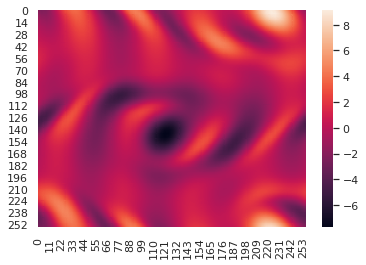

In [39]:
# Inverse x
y_g_plot = y_g.cpu().detach().numpy()
y_g_plot = y_g_plot.reshape(s,s)
ax = sns.heatmap(y_g_plot)

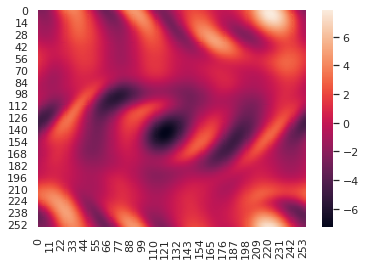

In [40]:
y_s_plot = y_s.cpu().detach().numpy()
y_s_plot = y_s_plot.reshape(s,s)
ax = sns.heatmap(y_s_plot)

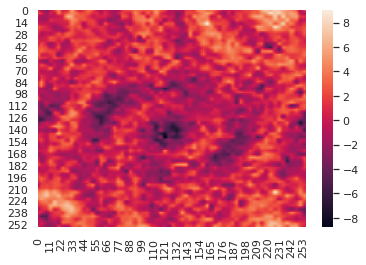

In [41]:
x_plot = xx.cpu().detach().numpy()
x_plot = x_plot.reshape(s,s)
ax = sns.heatmap(x_plot)

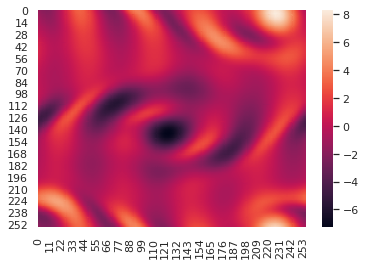

In [42]:
x_g_plot = xx_g.cpu().detach().numpy()
x_g_plot = x_g_plot.reshape(s,s)
ax = sns.heatmap(x_g_plot)